

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Final Project - Algorithmic Biases in Facial Recognition



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Pavlos Protopapas and Mark Glickman 


<hr style="height:2pt">

### TOC

- Literature review
- Description of the project goals
- Downloading, extracting and evaluating data
- EDA

<hr style="height:2pt">

In [13]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [15]:
#PLEASE RUN THIS CELL 
import requests
import os
import glob, cv2
import tarfile
import requests
import getpass
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.io import imread
import skimage.transform
from scipy.misc import imresize
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

from keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.layers import *
import random
from IPython.display import clear_output

from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

#os.getcwd()

## Overview</b></div>

We are using popular facial datasets (e.g., [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/data_infor.html) and [Labeled Faces in the Wild](https://scikit-learn.org/stable/datasets/index.html#the-labeled-faces-in-the-wild-face-recognition-dataset)) to evaluate algorithmic biases in facial classification. Bias can be introduced to an algorithm during training when a racially imbalanced training data set is used. The resulting model will inherently have more error in identifying underrepresented races, and therefore the algorithm will be biased towards better represented races in training datasets. Effects of this can be seen in pre-trained models (e.g., VGG16, VGG19) in Keras for image recognition that tend to have high error for recognizing non-white people. Our overarching goal is to reduce algorithmic bias by training a convolutional neural net (CNN) or other image recognition model using a more diverse training dataset and test it against an existing non-diverse training dataset (e.g., VGGFace2). 

### Literature Review</b></div>

A recent article by NPR$^1$ discussed racial algorithmic biases and their impact on practical applications such as the assessment of credit scores. Stephanie Kim also wrote an interesting article about how racial biases creep into neural net training and how they might be addressed.$^2$ Recently, Wang et al.$^{3,4}$ constructed a new Racial Faces in-the-Wild (RFW) database consisting of 625,000 images of 25,000 celebrities of different races. In a recent paper, Wang et al.$^3$ reported that the training dataset for VGGFace2 is comprised of 76.3% caucasian images and the labeled faces in the wild (LFW) is roughly 70% caucasian. 

$^1$ https://www.pbs.org/wgbh/nova/article/ai-bias/ <br>
$^2$ https://blog.algorithmia.com/racial-bias-in-facial-recognition-software/ <br>
$^3$ Mei Wang, Weihong Deng, Jiani Hu, Jianteng Peng, Xunqiang Tao, Yaohai Huang. Racial Faces in-the-Wild: Reducing Racial Bias by Deep Unsupervised Domain Adaptation. arXiv:1812.00194 <br>
$^4$ Mei Wang, Weihong Deng, Deep face recognition: A Survey. arXiv:1804.06655
$^5$ Keras pre-trained models. https://keras.rstudio.com/articles/applications.html

### Goals for the Project</b></div>

- Evaluate meta data of image data sets
- Perform classification of labeled image data
- Label VGGFace2 with races for a subset of the images

## Downloading & Extracting Data</b></div>

We will use popular face databases along with lesser know and newer databases that including labeling for race. Our data sources include

- VGGFace2: http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/data_infor.html
- Labeled Faces in the Wild (LFW): https://scikit-learn.org/stable/datasets/index.html#the-labeled-faces-in-the-wild-face-recognition-dataset
- Racial Faces in the Wild (RFW): http://www.whdeng.cn/RFW/index.html *pending permission from the authors
- UTKFace: https://susanqq.github.io/UTKFace/

### Download VGGFace2 data directly from the source

The VGGFace2 test dataset is almost 2 GB and the training dataset is roughly 36 GB. There are different ways to handle such large files, but for EDA we chose to download them directly to JupyterHub using the script below. For training a CNN, it will be impractical to use JupyterHub because the entire dataset will not fit on our allotted disk space. Therefore, we will research methods for handling large amounts of training data including using a subset of the data, storing it elsewhere and calling it into JupyterHub or Google Collab for training, or using another tool for handling large datasets for training neural nets.

In [73]:
# Function to download VGGFace2 data
def getVGGface(tarfile,extract=1):
    LOGIN_URL = "http://zeus.robots.ox.ac.uk/vgg_face2/login/"
    FILE_URL = "http://zeus.robots.ox.ac.uk/vgg_face2/get_file?fname=" + tarfile

    print('Please enter your VGG Face 2 credentials:')
    user_string = input('    User: ')
    password_string = getpass.getpass(prompt='    Password: ')

    payload = {
        'username': user_string,
        'password': password_string
    }

    session = requests.session()
    r = session.get(LOGIN_URL)

    if 'csrftoken' in session.cookies:
        csrftoken = session.cookies['csrftoken']
    elif 'csrf' in session.cookies:
        csrftoken = session.cookies['csrf']
    else:
        raise ValueError("Unable to locate CSRF token.")

    payload['csrfmiddlewaretoken'] = csrftoken

    r = session.post(LOGIN_URL, data=payload)

    filename = FILE_URL.split('=')[-1]

    with open(filename, "wb") as f:
        print(f"Downloading file: `{filename}`")
        r = session.get(FILE_URL, data=payload, stream=True)
        bytes_written = 0
        for data in r.iter_content(chunk_size=4096):
            f.write(data)
            bytes_written += len(data)
            MiB = bytes_written / (1024 * 1024)
            sys.stdout.write(f"\r{MiB:0.2f} MiB downloaded...")
            sys.stdout.flush()

    print("\nDone downloading.")
        

In [ ]:
# working directory to whatever folder you want to keep data in
os.chdir('/jupyteruser/41320362/data')
# Tar filename
tarfile = "vggface2_train.tar.gz"
#tarfile = "vggface2_test.tar.gz"
# Download and extract file
getVGGface(tarfile)

Please enter your VGG Face 2 credentials:
    User: wjablons
    Password: ········
4281.07 MiB downloaded...

In [ ]:
# Extract the file
filename = "data/" + tarfile
# Open the tar file
tar = tar.open(filename, "r:gz")
# Extract the file
tar.extractall()

Download VGGFace2 meta data:

In [18]:
# Download the meta data from VGGFace2 data set
# http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/meta_infor.html
os.chdir('/jupyteruser/41320362/data')
!wget http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/meta/train_list.txt
!wget http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/meta/test_list.txt
!wget http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/meta/identity_meta.csv
!wget http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/meta/class_overlap_vgg1_2.txt
!wget http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/meta/test_posttemp_imglist.txt
!wget http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/meta/bb_landmark.tar.gz

--2019-04-28 01:11:56--  http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/meta/train_list.txt
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62837801 (60M) [text/plain]
Saving to: ‘train_list.txt’

train_list.txt      100%[===================>]  59.93M  3.75MB/s    in 15s     

2019-04-28 01:12:12 (4.06 MB/s) - ‘train_list.txt’ saved [62837801/62837801]

--2019-04-28 01:12:12--  http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/meta/test_list.txt
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3387920 (3.2M) [text/plain]
Saving to: ‘test_list.txt’

test_list.txt       100%[===================>]   3.23M  3.26MB/s    in 1.0s    

2019-04-28 01:12:13 (3.26 MB/s) - ‘test_list.txt

Save meta data to dataframes:

In [23]:
os.chdir('/jupyteruser/41320362/data')
# Extract meta data and/or read it into data frames
vggTest = pd.read_csv('test_list.txt')
vggTrain = pd.read_csv('train_list.txt')
vggIdentity = pd.read_csv('identity_meta.csv',quotechar='"',skipinitialspace=True)
#vgg2_df = pd.read_csv(project_path + 'data/vggface2/identity_meta.csv',quotechar='"',skipinitialspace=True)

# Rename the image column
vggTest = vggTest.rename(columns={'n000001/0001_01.jpg':'imageid'})
display(vggTest.shape)
display(vggTest.head())
display(vggIdentity.head())

(169395, 1)

,imageid
0,n000001/0002_01.jpg
1,n000001/0003_01.jpg
2,n000001/0004_01.jpg
3,n000001/0005_01.jpg
4,n000001/0006_01.jpg


,Class_ID,Name,Sample_Num,Flag,Gender
0,n000001,"""14th_Dalai_Lama""",424,0,m
1,n000002,"""A_Fine_Frenzy""",315,1,f
2,n000003,"""A._A._Gill""",205,1,m
3,n000004,"""A._J._Buckley""",387,1,m
4,n000005,"""A._J._Pierzynski""",229,1,m


Visualize some images from the VGGFace test dataset:

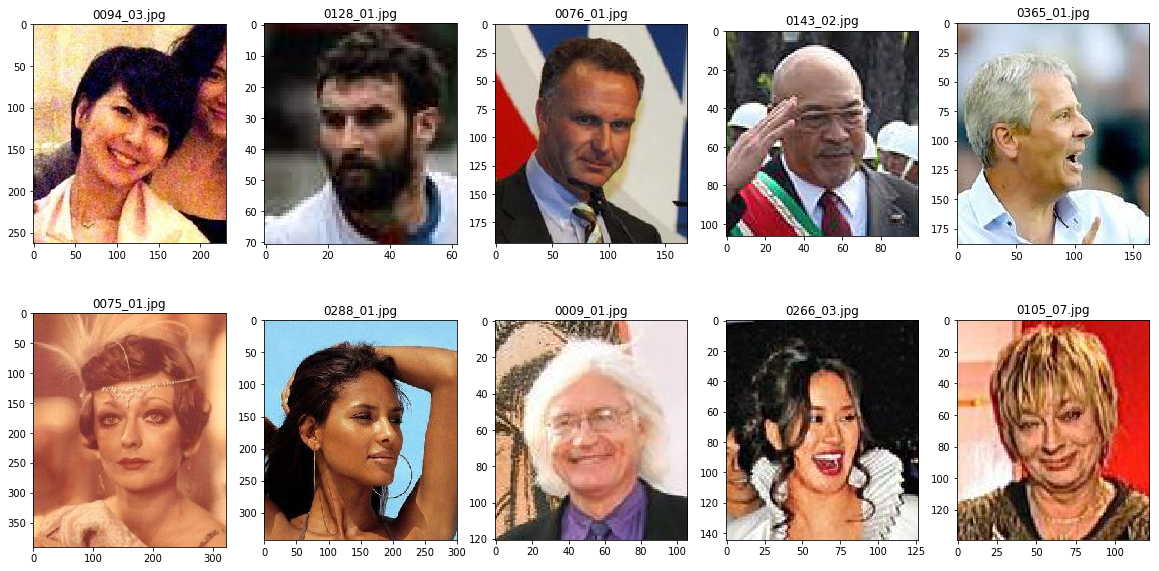

In [71]:
# Plot random images from VGGFace2 test dataset
fig = plt.figure(figsize=(20,10))
os.chdir('/jupyteruser/41320362/data')
for i in range(10):
    # Randomly choose directory to select an image from
    randDir = np.random.choice(os.listdir("test"))
    # Randomly choose an image from that directory
    imgFilename = np.random.choice(os.listdir("test/"+randDir))
    # Load the selected image
    img = load_img("test/" + randDir + "/" + imgFilename)    
    # Convert to an array for plotting
    img = img_to_array(img)/255.0
    # Add to the subplot figure for plotting
    ax  = fig.add_subplot(2,5,i+1)
    ax.imshow(img)
    ax.set_title("{}".format(imgFilename))
           

Visualize some images from the VGGFace train dataset:

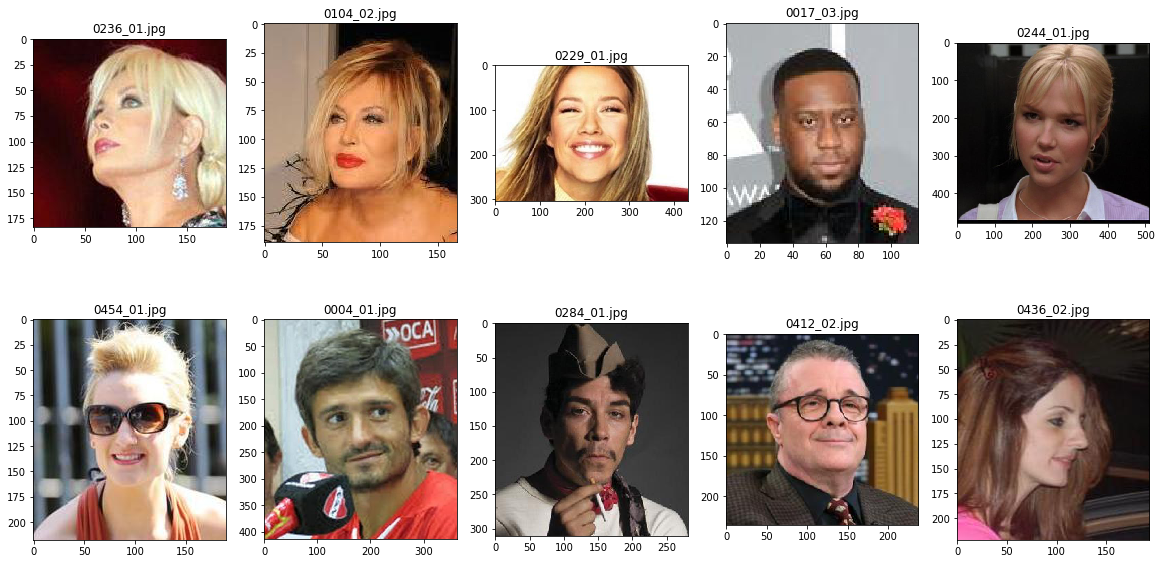

In [4]:
# Plot random images from VGGFace2 test dataset
fig = plt.figure(figsize=(20,10))
os.chdir('/jupyteruser/41320362/data')
for i in range(10):
    # Randomly choose directory to select an image from
    randDir = np.random.choice(os.listdir("train"))
    # Randomly choose an image from that directory
    imgFilename = np.random.choice(os.listdir("train/"+randDir))
    # Load the selected image
    img = load_img("train/" + randDir + "/" + imgFilename)    
    # Convert to an array for plotting
    img = img_to_array(img)/255.0
    # Add to the subplot figure for plotting
    ax  = fig.add_subplot(2,5,i+1)
    ax.imshow(img)
    ax.set_title("{}".format(imgFilename))
           

### Download the 'Faces in the Wild' dataset:

The Faces in the Wild dataset contains 30,281 faces, and can be downloaded relatively quickly and easily to JupyterHub without compromising disk space. Additionally, the Faces in the Wild labeled dataset is available as a canned dataset from `sklearn` and can be imported using `from sklearn.datasets import fetch_lfw_people`. We used both methods only for demonstration purposes, but will use the LFW dataset from `sklearn` to do some preliminary classification on age and gender labels.

The labels on the LFW dataset are 80% accurate according to the authors. The labels contain the names of people in the images, and the age is implied from the structure of the data directories which represent year, month, and day that the image was taken. 

In [55]:
!wget http://tamaraberg.com/faceDataset/faceData.tar.gz

--2019-04-27 13:47:23--  http://tamaraberg.com/faceDataset/faceData.tar.gz
Resolving tamaraberg.com (tamaraberg.com)... 54.221.205.183
Connecting to tamaraberg.com (tamaraberg.com)|54.221.205.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 597113070 (569M) [application/x-gzip]
Saving to: ‘faceData.tar.gz’

faceData.tar.gz     100%[===================>] 569.45M  9.56MB/s    in 56s     

2019-04-27 13:48:20 (10.1 MB/s) - ‘faceData.tar.gz’ saved [597113070/597113070]



Extract the 'Faces in the Wild' dataset

In [58]:
filename = "faceData.tar.gz"
# Open the tar file
tar = tar.open(filename, "r:gz")
# Extract the file
tar.extractall()

Visualize some images from 'Faces in the Wild'

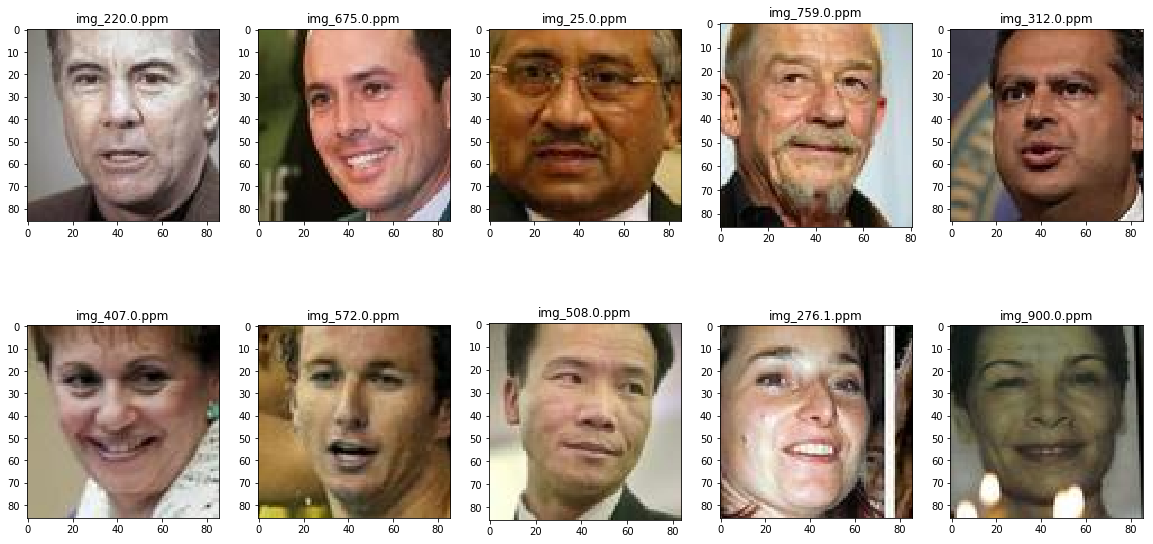

In [72]:
# Plot random images from faces in the wild test dataset
fig = plt.figure(figsize=(20,10))
os.chdir('/jupyteruser/41320362/data/faceData/2003')
for i in range(10):
    # Randomly choose from first directory 
    randDir1 = np.random.choice(os.listdir("."))
    # Randomly choose from second directory 
    randDir2 = np.random.choice(os.listdir(randDir1))
    # Randomly choose an image from that directory
    imgFilename = np.random.choice(os.listdir(randDir1+"/"+randDir2))
    # Load the selected image
    img = load_img(randDir1+"/"+randDir2 + "/" + imgFilename)    
    # Convert to an array for plotting
    img = img_to_array(img)/255.0
    # Add to the subplot figure for plotting
    ax  = fig.add_subplot(2,5,i+1)
    ax.imshow(img)
    ax.set_title("{}".format(imgFilename))
           

### Download the 'UTKFace' dataset:

The UTKFace dataset consists of 20k+ facial images "in the wild" with corresponding aligned and cropped images. Corresponding landmarks are provided as well as labels by age, gender, and ethnicity. Details of the labeled attributes are as follows (taken from the [source](https://susanqq.github.io/UTKFace/)):

- `age` is an integer from 0 to 116 
- `gender` is either male (0) or female (1)
- `race` is an integer from 0 to 4 mapped to white (0), black (1), asian (2), indian (3), and others (4, e.g., hispanic, latino, middle eastern)
- `date&time` is the datetime stamp that image was collected into the UTKFace dataset


In [11]:
os.chdir('/jupyteruser/41320362/data')
filename = "data/part2.tar.gz"
# Open the tar file
tar = tarfile.open(filename, "r:gz")
# Extract the file
tar.extractall()

In [ ]:
# Read in the UTKFace landmarks and labels


In [ ]:
# Plot random images from VGGFace2 test dataset
fig = plt.figure(figsize=(20,10))
os.chdir('/jupyteruser/41320362/data')
for i in range(10):
    # Randomly choose directory to select an image from
    randDir = np.random.choice(os.listdir("train"))
    # Randomly choose an image from that directory
    imgFilename = np.random.choice(os.listdir("train/"+randDir))
    # Load the selected image
    img = load_img("train/" + randDir + "/" + imgFilename)    
    # Convert to an array for plotting
    img = img_to_array(img)/255.0
    # Add to the subplot figure for plotting
    ax  = fig.add_subplot(2,5,i+1)
    ax.imshow(img)
    ax.set_title("{}".format(imgFilename))
           

## Exploratory Data Analysis </b></div>


### Preprocessing of the image data

The VGGFace2 images are non-uniform in size, but the faces in the images are centered relatively well. There are tools available that can detect and align faces such as the [MTCNN_face_detection_alignment](https://github.com/kpzhang93/MTCNN_face_detection_alignment).

add in more detail

Neither the VGGFace2 or the LFW datasets are labeled with race. Part of the work for this project will be to devise a method for labeling the datasets. 

### EDA of VGG data

The VGGFace2 images are non-uniform in size, but the faces in the images are centered relatively well. There are tools available that can detect and align faces such as the [MTCNN_face_detection_alignment](https://github.com/kpzhang93/MTCNN_face_detection_alignment).

add in more detail

Neither the VGGFace2 or the LFW datasets are labeled with race. Part of the work for this project will be to devise a method for labeling the datasets. 

In [30]:
nbmerge cs109b_final_project_algorithmic_bias_109_submit2.ipynb cs109b_final_project_algorithmic_bias_109_submit.ipynb > cs109b_final_project_algorithmic_bias_109_submit_merged.ipynb

SyntaxError: invalid syntax (<ipython-input-30-56ff80e92235>, line 1)

In [ ]:
img = cv2.imread('0001_01.jpg',0)
plt.hist(img.ravel(),256,[0,256]); plt.show()

### Clustering of LFW

The LFW dataset is uniform in size and the faces are well centered, and therefore very little preprocessing is needed. The general analysis of image data using PCA and support vector machines (SVM) was not addressed in the course material, and so we use the relatively clean LFW dataset to demonstrate clustering using image data. Because we do not have 

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

n_samples, n_features = X.shape
_, h, w = lfw_people.images.shape
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))

n_samples: 1288
n_features: 1850
n_classes: 7


In [ ]:
#https://github.com/kpzhang93/MTCNN_face_detection_alignment




# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Final Project - Algorithmic Biases in Facial Recognition



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Pavlos Protopapas and Mark Glickman 


<hr style="height:2pt">

In [ ]:
# image '0002_01.jpg' is loosely cropped, and '0001_01.jpg' is tightly cropped

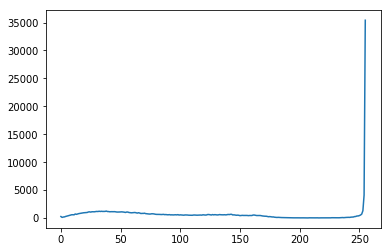

In [39]:
# img = cv2.imread('flower.png', 0)
img = cv2.imread('0002_01.jpg', 0)
histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
plt.plot(histr) 
plt.show() 

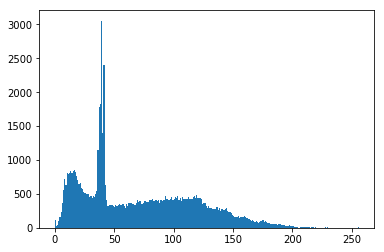

In [40]:
img = cv2.imread('0001_01.jpg',0)
plt.hist(img.ravel(),256,[0,256]); plt.show()

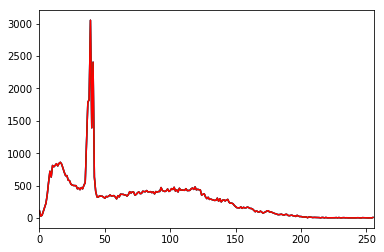

In [46]:
img = cv2.imread('0001_01.jpg',0)
color = ('b','g','r')
for i,col in enumerate(color):
#     histr = cv2.calcHist([img],[i],None,[256],[0,256])  
    histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

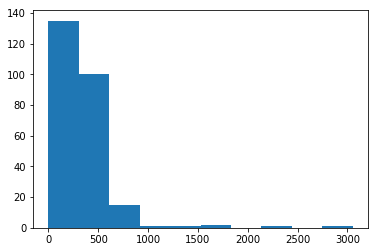

In [51]:
histi,bins = np.histogram(img.ravel(),256,[0,256])
plt.hist(histi)
plt.show()

In [45]:
# os.chdir('/jupyteruser/31376238/data')
os.getcwd()

'/jupyteruser/31376238/data'

**Shourya ------- EDA on VGG_Face2 dataset**

In [43]:
from PIL import Image

In [ ]:
'''On exploring the VGG_face2 dataset, we noticed the train dataset is a very huge file around 30GB.
We found it hard to access the data from JupyterHub. With a motivation to understand if the dataset is useful on a smaller scale 
we explored the test dataset which was approximately 2GB.

On exploring the test data we observed following details
a) we had around 500 unique personalities grouped into 500 classes.
b) Each class further had approximately 100 to 500 images of the same personality with different poses and background.
c) different images are of different sizes
d) 
'''

In [11]:
# We are reading entire test dataset using Keras ImageDataGenerator and resizing the images to (128, 128) 
# to maintain uniformity for all images.
datagen = ImageDataGenerator(rescale=1./255)
data_generator = datagen.flow_from_directory(directory="test/", class_mode="input",
                                            target_size=(128, 128), batch_size=32)

Found 169396 images belonging to 500 classes.


(-0.5, 239.5, 262.5, -0.5)

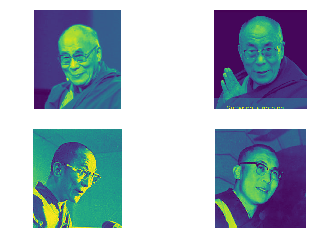

In [23]:
# Below pictures are from the first class which belongs to the Celebrity "Dalai Lama"
# Here we notice different poses of the same personality
img1 = cv2.imread('test/n000001/0001_01.jpg',0)
plt.subplot(221)
plt.imshow(img1)
plt.axis('off')
img1 = cv2.imread('test/n000001/0002_01.jpg',0)
plt.subplot(222)
plt.imshow(img1)
plt.axis('off')
img1 = cv2.imread('test/n000001/0481_01.jpg',0)
plt.subplot(223)
plt.imshow(img1)
plt.axis('off')
img1 = cv2.imread('test/n000001/0485_02.jpg',0)
plt.subplot(224)
plt.imshow(img1)
plt.axis('off')

In [50]:
## Compute number of pixels in an image
# Images from different Class belonging to the different celebrity, but they are of different sizes
img = Image.open('test/n000001/0001_01.jpg')
width, height = img.size
print("Dimensions of Image from Class 1:", img.size, "Total pixels:", width * height)

img = Image.open('test/n000040/0011_01.jpg')
width, height = img.size
print("Dimensions of Image from Class 2:", img.size, "Total pixels:", width * height)

Dimensions of Image from Class 1: (199, 227) Total pixels: 45173
Dimensions of Image from Class 2: (253, 244) Total pixels: 61732


In [52]:
# Images from same Class belonging to the same celebrity, but they are of different dimensions

img = Image.open('test/n000040/0001_01.jpg')
width, height = img.size
print("Dimensions of Image from Class 40, image number 0001_01:", img.size, "Total pixels:", width * height)
img = Image.open('test/n000040/0014_01.jpg')
width, height = img.size
print("Dimensions of Image from Class 40, image number 0014_01:", img.size, "Total pixels:", width * height)

Dimensions of Image from Class 40, image number 0001_01: (245, 280) Total pixels: 68600
Dimensions of Image from Class 40, image number 0014_01: (168, 191) Total pixels: 32088


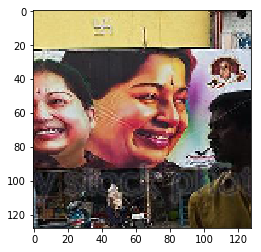

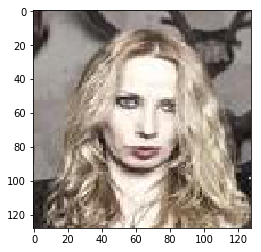

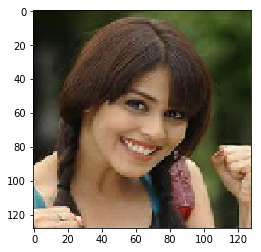

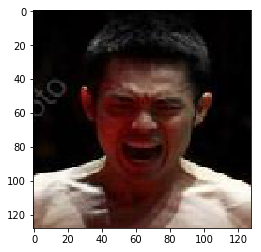

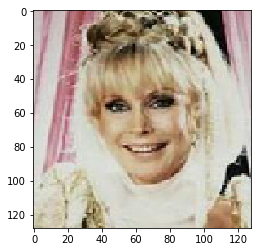

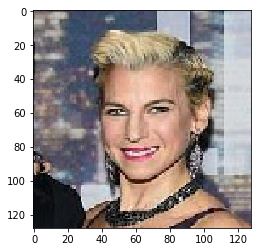

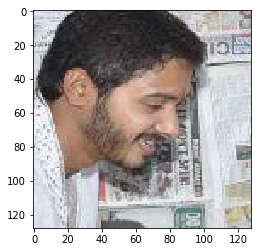

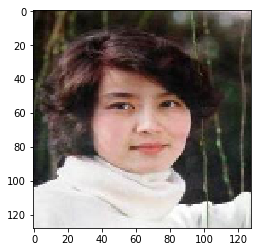

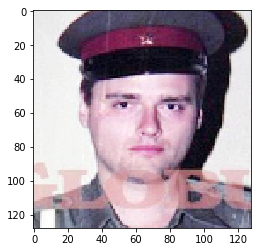

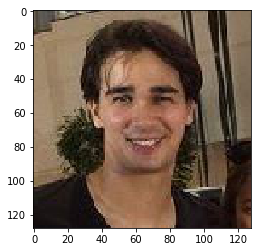

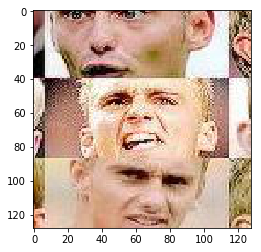

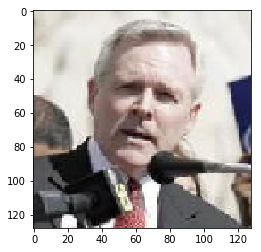

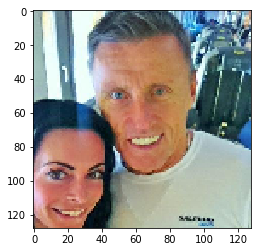

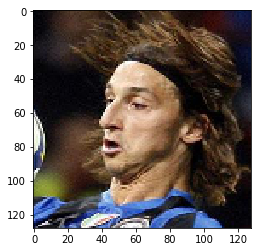

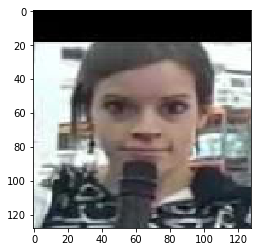

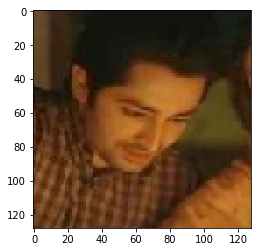

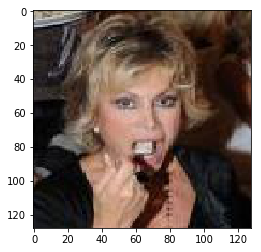

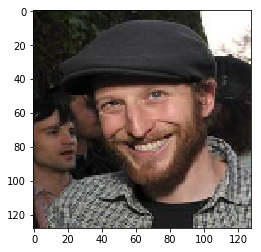

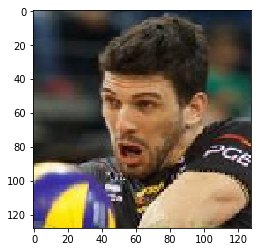

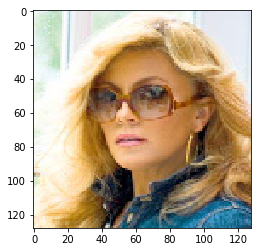

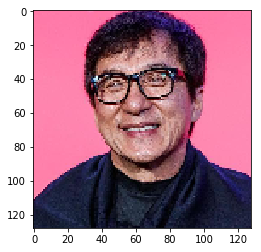

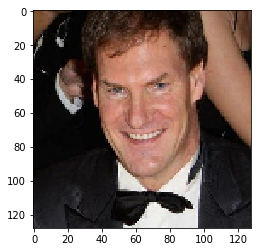

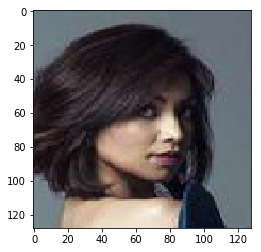

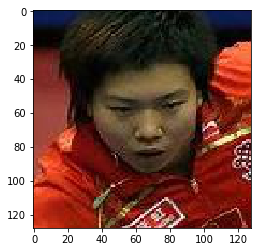

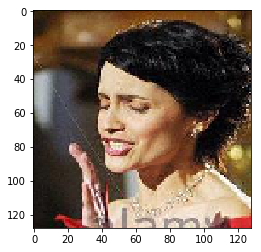

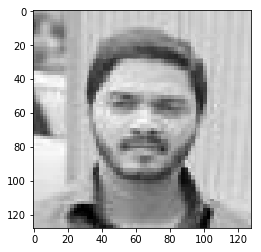

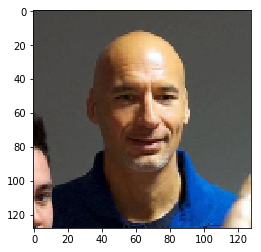

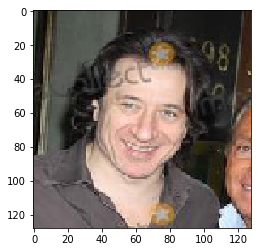

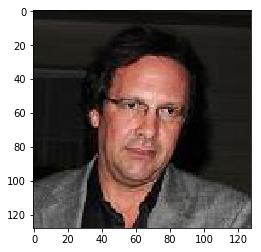

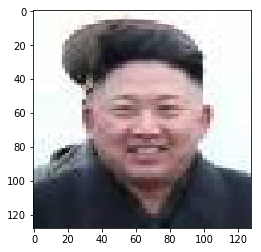

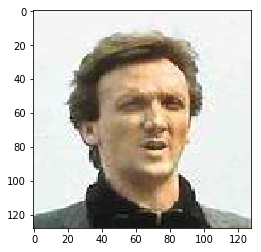

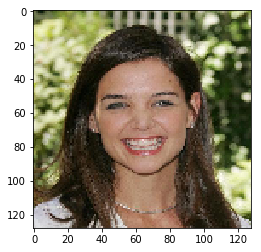

In [24]:
# We plotted a batch of images just to see how they look after resizing the images
# Here we noticed some images has more than 1 person in the photo
# Resizing the image has cropped some photos making it unusable while some photos are perfect for analysis after resize
# this is because we have images with different sizes

x_batch, y_batch = next(data_generator)
for i in range (0, 32):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()

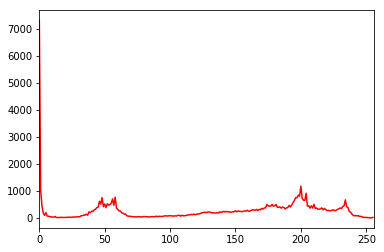

In [39]:
# Histogram of the number of pixels in an image of Class 1
img = cv2.imread('test/n000040/0001_01.jpg',0)
histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
plt.plot(histr,color = col)
plt.xlim([0,256])
plt.show()

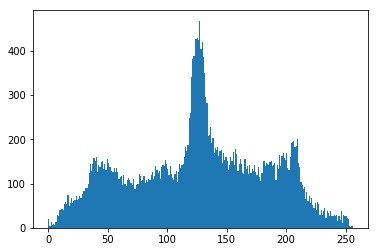

In [41]:
img = cv2.imread('test/n000040/0014_01.jpg',0)
plt.hist(img.ravel(),256,[0,256]); plt.show()